In [1]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import ldl

## Carga de Datos

In [2]:
file_name = './yk.txt'

with open(file_name) as f:
    Y = [y for line in f for y in map(lambda y: float(y), line.split(','))]

Y = np.array(Y[1:]) # Remove the list lenght

Y.shape

(256,)

## Descenso de Gradiente

In [3]:
def _back_tracking(x_k: np.array, 
                   grad_k: np.array, 
                   f :Callable[[], float], 
                   alpha:float=100.0, 
                   ro:float=0.95, 
                   c1:float=1E-4,
                   **kwargs) -> float:
    """ Search by Backtraking for an step size valid """
    f_kwargs = kwargs.get('f_kwargs', {})
    _alpha = alpha
    while f(x_k - _alpha * grad_k, **f_kwargs) > f(x_k, **f_kwargs) - c1 * _alpha * grad_k @ grad_k:
        _alpha = ro * _alpha
    return _alpha


def gradient_descent(X: np.array,
                     f: Callable[[np.array], np.array],
                     g: Callable[[np.array], np.array], 
                     H: Callable[[np.array], np.array],
                     mxitr: int=10000,
                     tol_x: float=1e-12,
                     tol_f: float=1e-12,
                     tol_g: float=1e-12,
                     msg='StepHess',
                     **kwargs):
    """ Gradient descent implementation
        
        Args:
            X: Start Point
            mxitr: Maximun number of iterations
            tol_x: Minimun value to reach the stopping criteria for norm(xk_1 - xk) / max(1, norm(xk)), used by default
            tol_g: Minimun value to reach the stopping criteria for norm(grad_k)
            tol_f: Minimun value to reach the stopping criteria for norm(f(xk_1) - f(xk)) / max(1, norm(f(xk)))
            f: Function to minimize
            g: Gradient of f
            H: Hessian of f
            msg: Type of computation for the step length (alpha)
                valid options are 'StepHess', 'Backtracking', 'StepFixed'
            
            alpha(float): Step size, required when 'msg'='StepFixed'
            backtraking_options(Dict): Dictionary with the Backtraking options; 'alpha', 'ro', 'c1'
            
            
        Returns:
            A tuple with the [ ||x_k+1 − x_k || ], [ f(x_k) ], [ grad(f(x_k)) ] values
            
    """
    Result = namedtuple('Result', 'x_log f_log stop_x_log stop_f_log stop_g_log')
    
    # History of values computed
    x_log = []; f_log = []
    stop_x_log = []; stop_f_log = []; stop_g_log = []
    
    # Initials values
    alpha_k = kwargs.get('alpha', 0.001)
    x_k = X
    x_k_next = None
    
    # Stop criterias
    stop_x = lambda x_k, x_k_next: np.linalg.norm(x_k_next - x_k) / max(np.linalg.norm(x_k), 1.0)
    stop_f = lambda f_x_k, f_x_k_next: np.abs(f_x_k_next - f_x_k) / max(np.abs(f_x_k), 1.0)
    stop_g = lambda grad_k: np.linalg.norm(grad_k)

    step = 0
    while True:
        # Compute gradient
        grad_k = g(x_k, **kwargs.get('g_kwargs', {}))
        hessian_k = H(x_k, **kwargs.get('H_kwargs', {}))

        # Compute step size
        if msg == 'StepHess':
            alpha_k = (grad_k @ grad_k) / (grad_k @ hessian_k @ grad_k)
        elif msg == 'Backtracking':
            alpha_k = _back_tracking(x_k, grad_k, f, f_kwargs=kwargs.get('g_kwargs', {}), **kwargs.get('backtraking_kwargs', {}))
        else:
            pass # value from alpha param

        # Compute next x
        x_k_next = x_k - alpha_k * grad_k
        
        # Save algorithm logs
        f_x_k = f(x_k, **kwargs.get('f_kwargs', {}))
        f_x_k_next = f(x_k_next, **kwargs.get('f_kwargs', {}))
        x_log.append(x_k_next)
        f_log.append(f_x_k_next)
        stop_x_log.append(stop_x(x_k, x_k_next))
        stop_g_log.append(stop_g(grad_k))
        stop_f_log.append(stop_f(f_x_k, f_x_k_next))
        
        if kwargs.get('log', False) and step % kwargs.get('step_log', 100) == 0:
            print(f_log[-1], stop_x_log[-1], stop_g_log[-1], stop_f_log[-1])

        # Stop criteria
        if mxitr < step or stop_x_log[-1] < tol_x or stop_g_log[-1] < tol_g or stop_f_log[-1] < tol_f:
            break

        # Update x_k
        x_k = x_k_next
        step += 1

    return Result(np.array(x_log), np.array(f_log), np.array(stop_x_log), np.array(stop_f_log), np.array(stop_g_log))


## Newton Method

In [4]:
def newton_method(X: np.array,
                  f: Callable[[np.array], np.array],
                  g: Callable[[np.array], np.array], 
                  H: Callable[[np.array], np.array],
                  mxitr: int=10000,
                  tol_x: float=1e-12,
                  tol_f: float=1e-12,
                  tol_g: float=1e-12,
                  **kwargs):
    """ Newton Method implementation
        
        Args:
            X: Start Point
            mxitr: Maximun number of iterations
            tol_x: Minimun value to reach the stopping criteria for norm(xk_1 - xk) / max(1, norm(xk)), used by default
            tol_g: Minimun value to reach the stopping criteria for norm(grad_k)
            tol_f: Minimun value to reach the stopping criteria for norm(f(xk_1) - f(xk)) / max(1, norm(f(xk)))
            f: Function to minimize
            g: Gradient of f
            H: Hessian of f
            
            alpha(float): Step size, required when 'msg'='StepFixed'
            
        Returns:
            A tuple with the [ ||x_k+1 − x_k || ], [ f(x_k) ], [ grad(f(x_k)) ] values
            
    """
    Result = namedtuple('Result', 'x_log f_log stop_x_log stop_f_log stop_g_log')
    
    # History of values computed
    x_log = []; f_log = []
    stop_x_log = []; stop_f_log = []; stop_g_log = []
    
    # Initials values
    alpha_k = kwargs.get('alpha', 1.0)
    x_k = X
    x_k_next = None
    
    # Stop criterias
    stop_x = lambda x_k, x_k_next: np.linalg.norm(x_k_next - x_k) / max(np.linalg.norm(x_k), 1.0)
    stop_f = lambda f_x_k, f_x_k_next: np.abs(f_x_k_next - f_x_k) / max(np.abs(f_x_k), 1.0)
    stop_g = lambda grad_k: np.linalg.norm(grad_k)
                                                                         
    step = 0
    while True:
        # Compute gradient
        grad_k = g(x_k, **kwargs.get('g_kwargs', {}))
        hessian_k = H(x_k, **kwargs.get('H_kwargs', {}))
        
        # Ensure that the H is positive semidefined
        _, D, _ = ldl(hessian_k)
        min_l = np.min(np.sum(D, axis=0))
        if min_l < 0:
            hessian_k = hessian_k - min_l

        # Compute next x
        x_k_next = x_k - alpha_k * (np.linalg.inv(hessian_k) @ grad_k)
        
        # Save algorithm logs
        f_x_k = f(x_k, **kwargs.get('f_kwargs', {}))
        f_x_k_next = f(x_k_next, **kwargs.get('f_kwargs', {}))
        x_log.append(x_k_next)
        f_log.append(f_x_k_next)
        stop_x_log.append(stop_x(x_k, x_k_next))
        stop_g_log.append(stop_g(grad_k))
        stop_f_log.append(stop_f(f_x_k, f_x_k_next))
        
        if kwargs.get('log', False) and step % kwargs.get('step_log', 100) == 0:
            print(f_log[-1], stop_x_log[-1], stop_g_log[-1], stop_f_log[-1])

        # Stop criteria
        if mxitr < step or stop_x_log[-1] < tol_x or stop_g_log[-1] < tol_g or stop_f_log[-1] < tol_f:
            break

        # Update x_k
        x_k = x_k_next
        step += 1

    return Result(np.array(x_log), np.array(f_log), np.array(stop_x_log), np.array(stop_f_log), np.array(stop_g_log))

## Definición de la funcion

In [5]:
def f1(X: np.array=None, Y: np.array=None, _lambda: float=1.0):
    """ Returns the evaluation for f """
    return np.sum((X - Y)**2 ) + _lambda * np.sum((X[1:] - X[:-1])**2)

In [6]:
def gradient(X: np.array=None, Y: np.array=None, _lambda:float=1.0):
    """ Return the evaluation for the gradient of f """
    s1 = X - Y
    s2 = X[1:] - X[:-1]
    return 2 * s1 + 2 * _lambda * (np.concatenate([[0], s2]) - np.concatenate([s2, [0]]))

In [7]:
def hessian(X: np.array=None, _lambda :float=1.0):
    """ Return the evaluation for the Hessian of f """
    size = X.shape[0]
    h = np.zeros((size, size))
    for i in range(size):
        h[i][i] = 2 * _lambda + 2 if i == 0 or i == size-1 else 4 * _lambda + 2
        if i > 0:
            h[i][i-1] = h[i-1][i] = - 2 * _lambda
    return h

## Ejecuciones Para Método de Newton

In [8]:
def plot_xy(x, y, title=''):
    plt.figure(figsize=(16, 8))
    plt.plot(x)
    plt.plot(Y)
    plt.title(title)
    plt.xlabel('Index i')
    plt.ylabel('Values for x_i and y_i')
    plt.legend(['X', 'Y'])
    plt.grid(True)
    plt.show()

In [9]:
X = np.array(range(0, len(Y)))

### Lambda = 1

Time: 0.25670361518859863s
[5.46928500e-01 1.00638198e-16]


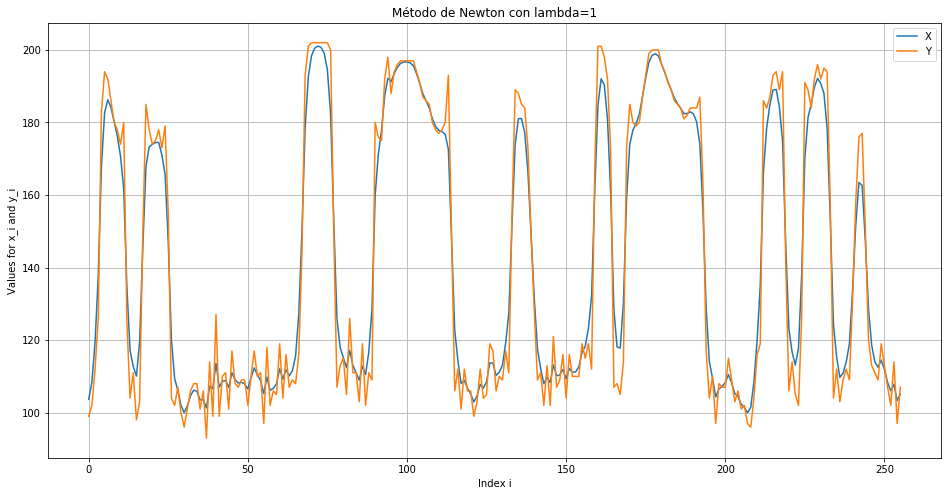

In [10]:
_lambda = 1
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 10000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'alpha': 1,
}

toc = time.time()
results = newton_method(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print(results.stop_x_log)
plot_xy(results.x_log[-1], Y, "Método de Newton con lambda=1")

### Lambda = 100

Time: 0.10007882118225098s
[5.02338271e-01 3.25256674e-15]


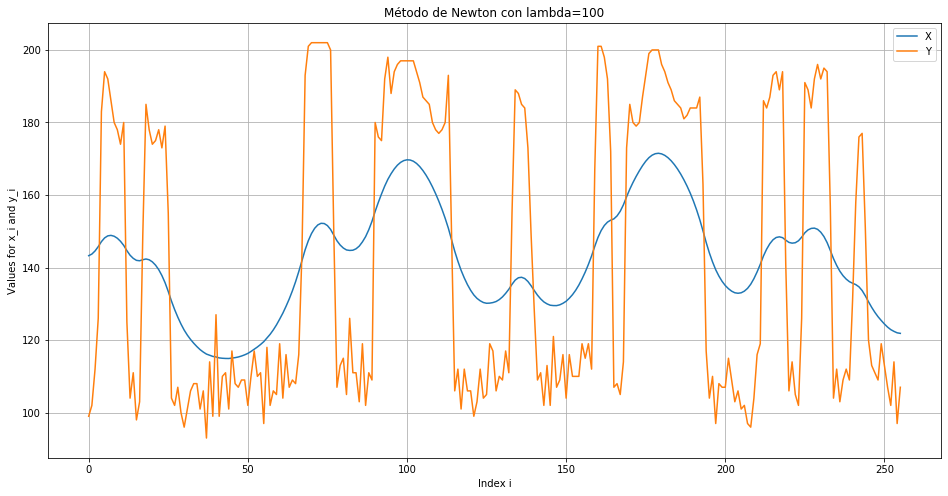

In [11]:
_lambda = 100
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 10000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'alpha': 1,
}

toc = time.time()
results = newton_method(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print(results.stop_x_log)
plot_xy(results.x_log[-1], Y, "Método de Newton con lambda=100")

### Lambda = 1000

Time: 0.04298567771911621s
[4.93791565e-01 6.27304335e-15]


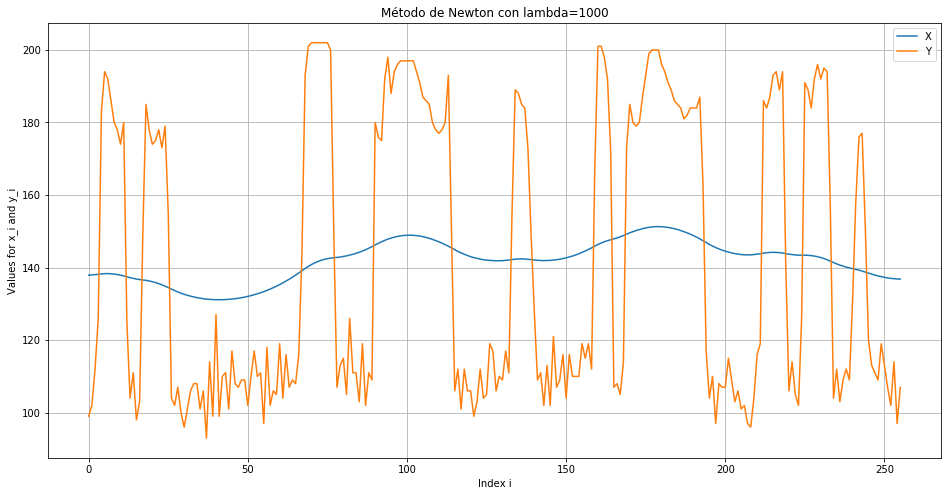

In [12]:
_lambda = 1000
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 10000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'alpha': 1,
}

toc = time.time()
results = newton_method(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print(results.stop_x_log)
plot_xy(results.x_log[-1], Y, "Método de Newton con lambda=1000")

## Ejecuciones para Método de Gradiente

### Lambda = 1

Time: 0.039086341857910156s
Iterations 32
[9.54189678e-01 3.88217085e-01 7.64902565e-02 2.26672259e-02
 8.24990980e-03 3.18387807e-03 1.28417456e-03 5.28469898e-04
 2.21063917e-04 9.33333309e-05 3.97121103e-05 1.69827540e-05
 7.29345630e-06 3.14193646e-06 1.35691254e-06 5.87193892e-07
 2.54501421e-07 1.10459146e-07 4.79900163e-08 2.08705080e-08
 9.08250107e-09 3.95548807e-09 1.72342491e-09 7.51332141e-10
 3.27649434e-10 1.42949431e-10 6.23809894e-11 2.72322726e-11
 1.18901282e-11 5.19314981e-12 2.26817961e-12 9.90900042e-13]


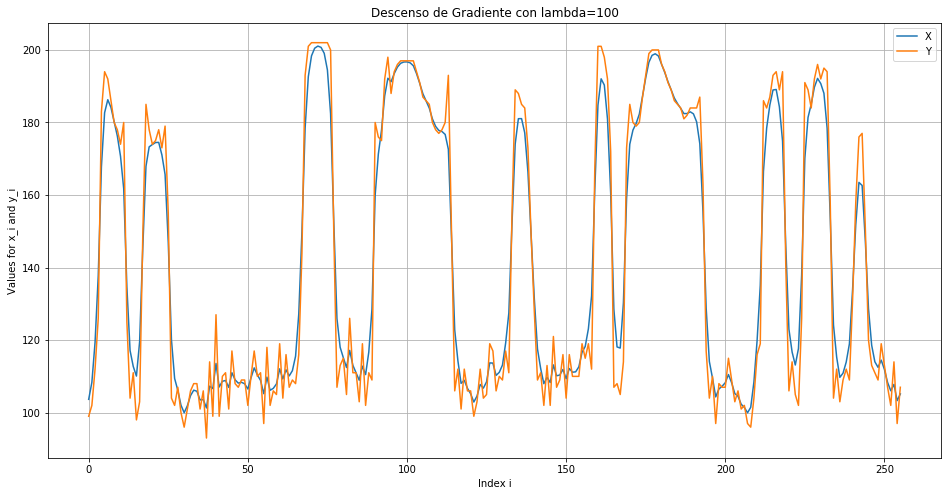

In [13]:
_lambda = 1
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 10000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'msg':'StepHess',
    # 'msg':'StepFixed',
    # 'msg':'Backtracking',
    'alpha': 0.17,
    'backtraking_kwargs': {
        'alpha': 0.17, 
        'ro': 0.001, 
        'c1': 1e-14
    }
}

toc = time.time()
results = gradient_descent(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print("Iterations %d" % (len(results.stop_f_log)))
print(results.stop_f_log)
plot_xy(results.x_log[-1], Y, "Descenso de Gradiente con lambda=100")

### Lambda = 100

Time: 2.936807870864868s
Iterations 2376
[1.54840669e-01 9.16262258e-02 2.48278788e-02 ... 1.01872956e-12
 1.00844572e-12 9.98161882e-13]


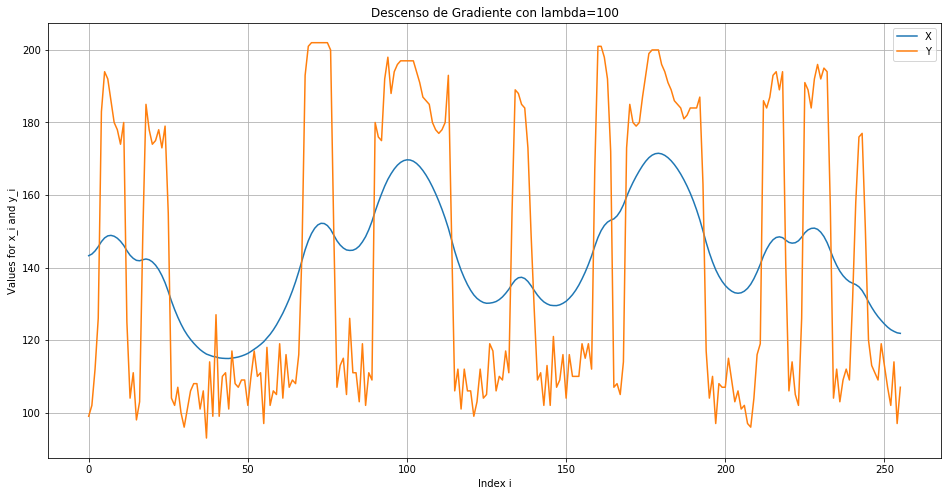

In [14]:
_lambda = 100
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 10000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'msg':'StepHess',
    # 'msg':'StepFixed',
    # 'msg':'Backtracking',
    'alpha': 0.0024,
    'backtraking_kwargs': {
        'alpha': 0.0024, 
        'ro': 0.001, 
        'c1': 1e-14
    }
}

toc = time.time()
results = gradient_descent(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print("Iterations %d" % (len(results.stop_f_log)))
print(results.stop_f_log)
plot_xy(results.x_log[-1], Y, "Descenso de Gradiente con lambda=100")

### Lambda = 1000

Time: 29.43853235244751s
Iterations 19135
[4.35045087e-03 2.98171178e-03 1.61856867e-03 ... 1.00203472e-12
 1.00105887e-12 9.99757740e-13]


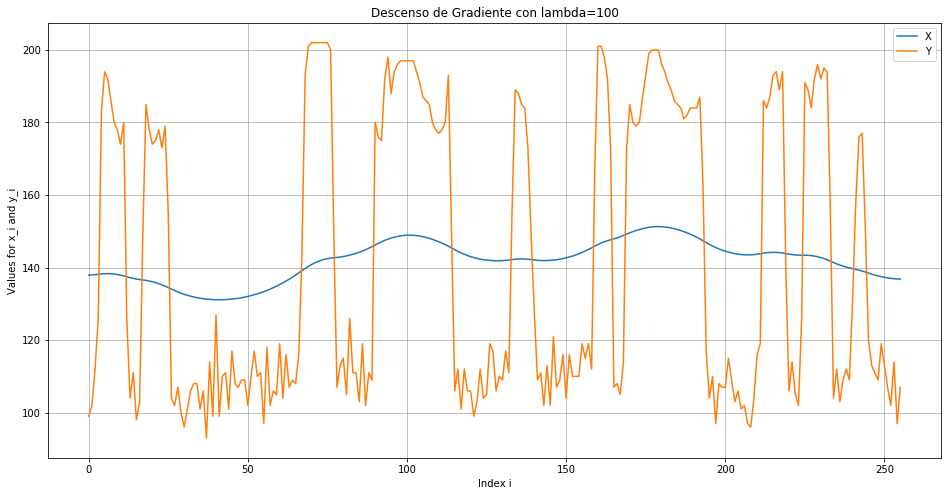

In [15]:
_lambda = 1000
params = {
    'X': X,
    'f': f1,
    'f_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'g': gradient,
    'g_kwargs': {
        'Y': Y,
        '_lambda': _lambda
    },
    'H': hessian,
    'H_kwargs': {
        '_lambda': _lambda
    },
    'mxitr': 100000,
    'tol_x': 1e-12,
    'tol_g': 1e-12,
    'tol_f': 1e-12,
    'msg':'StepHess',
    # 'msg':'StepFixed',
    # 'msg':'Backtracking',
    'alpha': 0.0001,
    'backtraking_kwargs': {
        'alpha': 0.0001,
        'ro': 0.001, 
        'c1': 1e-14
    }
}

toc = time.time()
results = gradient_descent(**params)
tic = time.time()
print("Time: %ss" % (tic-toc))
print("Iterations %d" % (len(results.stop_f_log)))
print(results.stop_f_log)
plot_xy(results.x_log[-1], Y, "Descenso de Gradiente con lambda=100")